# EDA Land Cover

In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent.parent))

from config import raw_files, processed_files

In [2]:
import xarray as xr
import os
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import rasterio
import geopandas
import seaborn as sns

## Loading the Data

### Land Cover Data

In [3]:
from shapely import wkt

filepath = processed_files["landcover"]
df = pd.read_csv(filepath)

# Convert 'geometry' column from WKT string to shapely geometry
df['geometry'] = df['geometry'].apply(wkt.loads)

gdf = geopandas.GeoDataFrame(df, geometry='geometry')
gdf.set_crs(epsg=4326, inplace=True)  


,ID,GRIDCODE,AREA,LCCCODE,geometry
0,4,210,6.228187e+06,7001 // 8001,"POLYGON ((6.41528 37.08696, 6.43103 37.0855, 6..."
1,2,210,6.242408e+06,7001 // 8001,"POLYGON ((7.18084 37.07917, 7.17998 37.08091, ..."
2,1,210,1.482995e+06,7001 // 8001,"POLYGON ((7.37137 37.08194, 7.3709 37.08717, 7..."
3,8,50,4.590841e+08,21497-121340,"POLYGON ((6.12361 36.68472, 6.12361 36.69306, ..."
4,13,210,6.371533e+06,7001 // 8001,"POLYGON ((6.26181 37.02361, 6.26193 37.02514, ..."
...,...,...,...,...,...
438508,52055,201,1.646170e+05,6001,"POLYGON ((9.62361 30.27083, 9.62361 30.26806, ..."
438509,52058,200,1.482200e+05,0011,"POLYGON ((9.56891 30.2625, 9.57361 30.2625, 9...."
438510,52057,201,2.797149e+06,6001,"POLYGON ((9.57053 30.25694, 9.57083 30.25694, ..."
438511,52056,201,6.585450e+05,6001,"POLYGON ((9.62083 30.25972, 9.62083 30.25694, ..."


In [4]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 438513 entries, 0 to 438512
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   ID        438513 non-null  int64   
 1   GRIDCODE  438513 non-null  int64   
 2   AREA      438513 non-null  float64 
 3   LCCCODE   438513 non-null  object  
 4   geometry  438513 non-null  geometry
dtypes: float64(1), geometry(1), int64(2), object(1)
memory usage: 16.7+ MB


In [ ]:
filepath = processed_files["landcover_legend"]
df = pd.read_csv(filepath)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LC           45 non-null     object 
 1   LPos         45 non-null     float64
 2   LCCCode      45 non-null     object 
 3   LCCMode      45 non-null     float64
 4   LCCLevel     45 non-null     object 
 5   LCCOwnLabel  45 non-null     object 
 6   LCCOwnDescr  0 non-null      float64
 7   LCCLabel     47 non-null     object 
 8   MapCode      45 non-null     object 
dtypes: float64(3), object(6)
memory usage: 3.4+ KB


## LCCCODE

In [5]:
gdf['LCCCODE'].value_counts()

LCCCODE
0011                                172221
6001                                 61857
20049 // 20058                       47560
0003 / 0004                          31891
6004                                 25951
0004 // 0003                         24856
20058                                24520
21446 // 21450-121340 / 21454        16002
11498                                14872
21450                                 8248
21518                                 5432
21497-121340                          2575
21499-121340                           818
11490 // 11494                         550
7001 // 8001                           538
21454 // 21446 // 21450                405
0010                                   145
21497-15045                             49
6020                                     8
21496-121340 // 21497-129401             8
41638-60686-R2 // 41898-60686-R2         6
21454 // 21465                           1
Name: count, dtype: int64

In [7]:
df['LCCCODE'].nunique(), gdf['LCCCODE'].nunique()

(22, 22)

### Filter Relevant LCCCodes

In [24]:
df = df[df['LCCCode'].isin(np.unique(gdf['LCCCODE']))]
df['LCCCode'].nunique(), gdf['LCCCODE'].nunique()

(22, 22)

In [25]:
df.head()

,LC,LPos,LCCCode,LCCMode,LCCLevel,LCCOwnLabel,LCCOwnDescr,LCCLabel,MapCode
7,0Dichotomous Phase,1.0,0010,0.0,B15,Artficial surfaces and associated areas,NaN,Artificial Surfaces and Associated Area(s),190
8,0Dichotomous Phase,1.0,0011,0.0,B16,Bare areas,NaN,Bare Area(s),200
9,1Consolidated Bare Areas,1.0,6001,0.0,A1,Consolidated bare areas,NaN,Consolidated Material(s),201
10,2Unconsolidated Bare Areas,1.0,6004,0.0,A2,Non - consolidated bare areas,NaN,Unconsolidated Material(s),202
11,Error,1.0,6020,0.0,A5B13,Salt hardpans,NaN,Bare Soil And/Or Unconsolidated Material(s) Wi...,203


In [26]:
df.set_index('LCCCode')['LC']


LCCCode
0010                                        0Dichotomous Phase
0011                                        0Dichotomous Phase
6001                                  1Consolidated Bare Areas
6004                                2Unconsolidated Bare Areas
6020                                                     Error
7001 // 8001                                      9Mixed Class
41638-60686-R2 // 41898-60686-R2                  9Mixed Class
11498                                                    Error
11490 // 11494                                    9Mixed Class
0003 / 0004                                       9Mixed Class
0004 // 0003                                      9Mixed Class
21496-121340 // 21497-129401                      9Mixed Class
21497-121340                                             Error
21499-121340                                             Error
21497-15045                                              Error
21446 // 21450-121340 / 21454                  

## Map Display

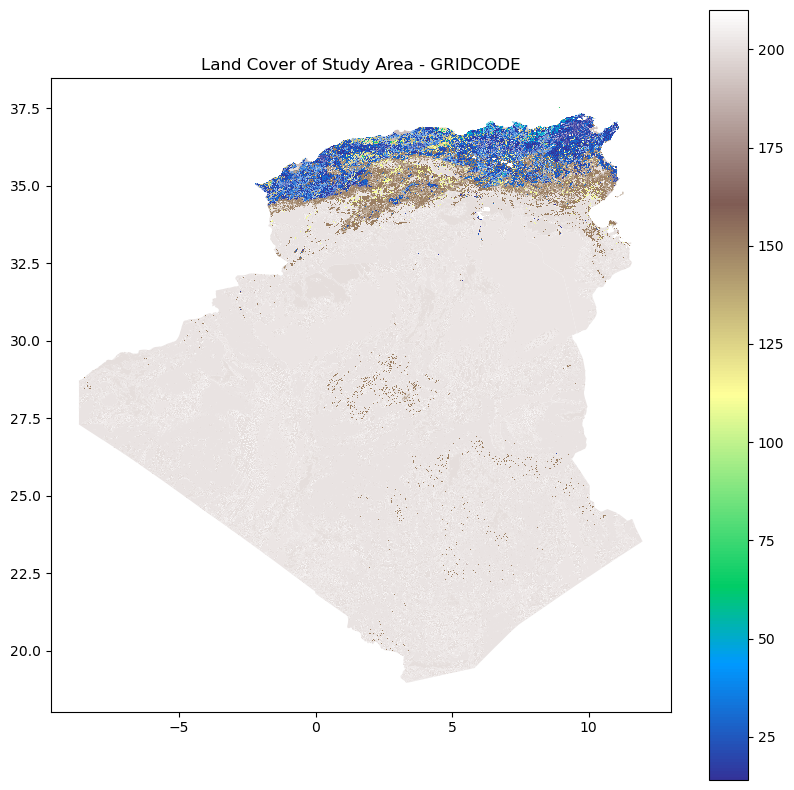

In [13]:
gdf.plot(column='GRIDCODE', legend=True, figsize=(10, 10), cmap='terrain')
plt.title('Land Cover of Study Area - GRIDCODE')
plt.show()

## Land Cover Distribution

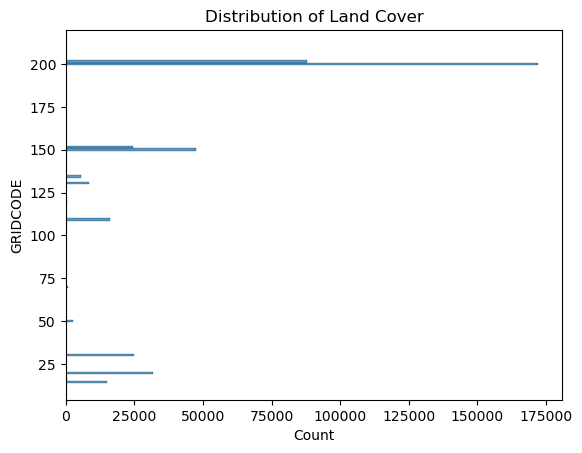

In [ ]:
sns.histplot(gdf, y='GRIDCODE')
plt.title('Distribution of Land Cover')
plt.show()

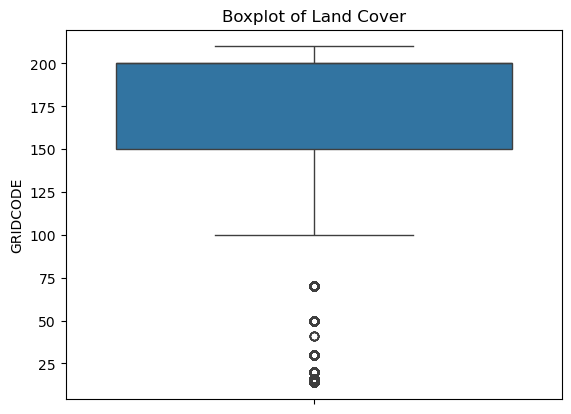

In [12]:
sns.boxplot(gdf, y='GRIDCODE')
plt.title('Boxplot of Land Cover')
plt.show()

In [29]:
df[(df['LCCCode'] == "0011") | (df['LCCCode'] == "6001")]

,LC,LPos,LCCCode,LCCMode,LCCLevel,LCCOwnLabel,LCCOwnDescr,LCCLabel,MapCode
8,0Dichotomous Phase,1.0,0011,0.0,B16,Bare areas,NaN,Bare Area(s),200
9,1Consolidated Bare Areas,1.0,6001,0.0,A1,Consolidated bare areas,NaN,Consolidated Material(s),201


**Try LCCCode * Area to measure actual appearance frequency instead of simple frequency**